In [33]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
#       if builtins is not defined
# sudo pip install -U future

import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

In [34]:
# turns list of integers into an int
# Ex.
# build_state([1,2,3,4,5]) -> 12345
def build_state(features):
  return int("".join(map(lambda feature: str(int(feature)), features)))

In [35]:
def to_bin(value, bins):
  return np.digitize(x=[value], bins=bins)[0]

In [36]:
class FeatureTransformer:
  def __init__(self):
    # Note: to make this better you could look at how often each bin was
    # actually used while running the script.
    # It's not clear from the high/low values nor sample() what values
    # we really expect to get.
    self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
    self.cart_velocity_bins = np.linspace(-2, 2, 9) # (-inf, inf) (I did not check that these were good values)
    self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
    self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9) # (-inf, inf) (I did not check that these were good values)

  def transform(self, observation):
    # returns an int
    cart_pos, cart_vel, pole_angle, pole_vel = observation
    return build_state([
      to_bin(cart_pos, self.cart_position_bins),
      to_bin(cart_vel, self.cart_velocity_bins),
      to_bin(pole_angle, self.pole_angle_bins),
      to_bin(pole_vel, self.pole_velocity_bins),
    ])

In [37]:
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.feature_transformer = feature_transformer

    num_states = 10**env.observation_space.shape[0]
    num_actions = env.action_space.n
    self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))

  def predict(self, s):
    x = self.feature_transformer.transform(s)
    return self.Q[x]

  def update(self, s, a, G):
    x = self.feature_transformer.transform(s)
    self.Q[x,a] += 1e-2*(G - self.Q[x,a])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      p = self.predict(s)
      return np.argmax(p)

In [38]:
def play_one(model, eps, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 10000:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    totalreward += reward

    if done and iters < 199:
      reward = -300

    # update the model using the best reward from the action
    G = reward + gamma*np.max(model.predict(observation))
    model.update(prev_observation, action, G)

    iters += 1

  return totalreward

In [39]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

episode: 0 total reward: 19.0 eps: 1.0
episode: 100 total reward: 23.0 eps: 0.09950371902099892
episode: 200 total reward: 29.0 eps: 0.07053456158585983
episode: 300 total reward: 20.0 eps: 0.0576390417704235
episode: 400 total reward: 63.0 eps: 0.04993761694389223
episode: 500 total reward: 33.0 eps: 0.04467670516087703
episode: 600 total reward: 63.0 eps: 0.04079085082240021
episode: 700 total reward: 118.0 eps: 0.0377694787300249
episode: 800 total reward: 182.0 eps: 0.03533326266687867
episode: 900 total reward: 56.0 eps: 0.03331483023263848
episode: 1000 total reward: 57.0 eps: 0.0316069770620507
episode: 1100 total reward: 122.0 eps: 0.03013743873394561
episode: 1200 total reward: 128.0 eps: 0.028855492841238062
episode: 1300 total reward: 178.0 eps: 0.027724348650071385
episode: 1400 total reward: 77.0 eps: 0.02671658425726324
episode: 1500 total reward: 122.0 eps: 0.025811286645983367
episode: 1600 total reward: 196.0 eps: 0.02499219116020307
episode: 1700 total reward: 132.0 e

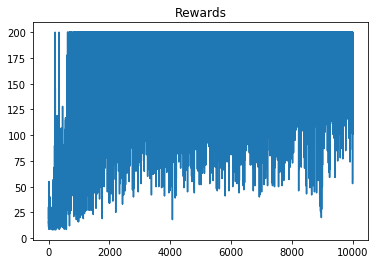

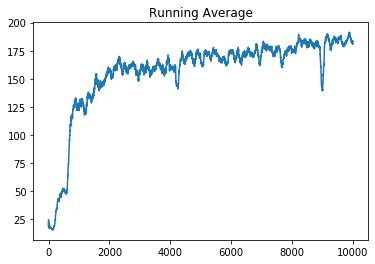

In [40]:
if __name__ == '__main__':
  env = gym.make('CartPole-v0')
  ft = FeatureTransformer()
  model = Model(env, ft)
  gamma = 0.9

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  N = 10000
  totalrewards = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps)
  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)

In [41]:
cart_position_bins = np.linspace(-2.4, 2.4, 9)

In [42]:
cart_position_bins

array([-2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4])

In [43]:
to_bin(-7, cart_position_bins)

0

In [44]:
#Q = np.random.uniform(low=-1, high=1, size=(10**4, 2))

In [45]:
Q.shape

(10000, 2)

In [46]:
env.observation_space.shape

(4,)

In [47]:
Q[17]

array([0.91700423, 0.04356807])

In [50]:
np.max(model.predict([-9.97385502e-01,  1.61251677e+38,  1.14053406e-01, -1.04396676e+38]))

-0.12324720679552925

In [51]:
model.predict([-9.97385502e-01,  1.61251677e+38,  1.14053406e-01, -1.04396676e+38])

array([-0.83968746, -0.12324721])